<a href="https://colab.research.google.com/github/AbhishekMathur11/Robot-Localization-with-Python-and-Particle-Filters/blob/main/robot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Robot Localization with Python and Particle Filters
===================================================

Import libraries and load map.

In [ ]:
!pip install opencv-python

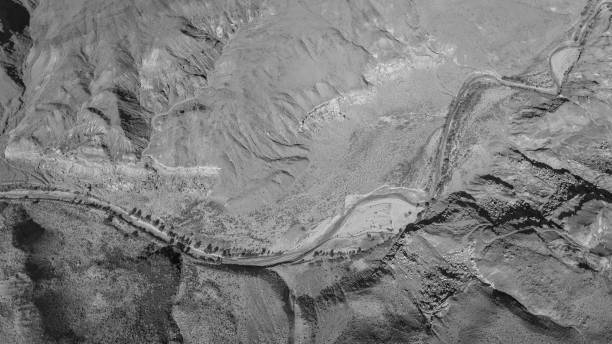

344 612


In [7]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

map = cv2.imread("terrain.jpg",0)
cv2_imshow(map)
HEIGHT, WIDTH = map.shape
print(HEIGHT, WIDTH)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


(344, 612, 3)
Input shape for MiDaS: torch.Size([1, 3, 224, 384])


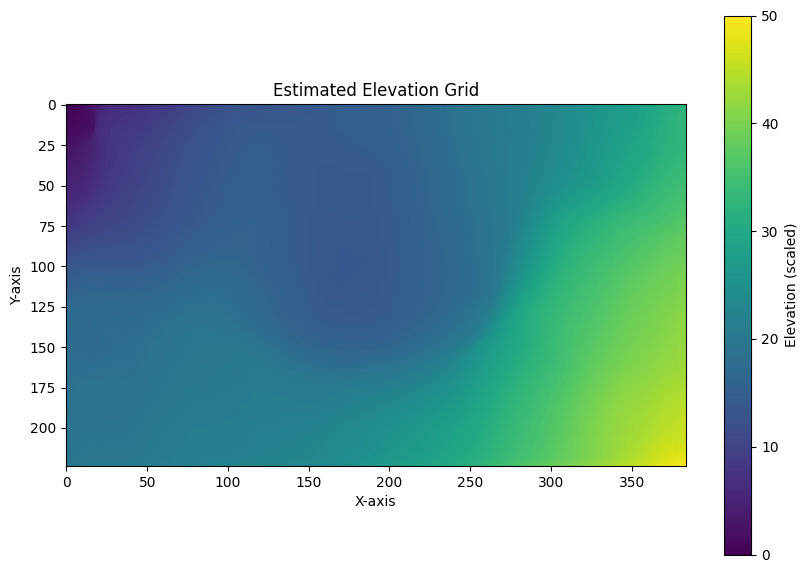

In [26]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained MiDaS model
model = torch.hub.load("intel-isl/MiDaS", "MiDaS")
model.eval()

# Load the MiDaS transformation pipeline
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.default_transform

# Load the terrain image (grayscale or RGB)
image_path = "/content/terrain.jpg"  # Replace with your image path
img = cv2.imread(image_path)
print(img.shape)

# Ensure the image is in RGB format
if len(img.shape) == 2 or img.shape[2] == 1:  # Grayscale
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Convert BGR (default from OpenCV) to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Prepare the image for the MiDaS model
input_batch = transform(img)  # Add batch dimension

# Debugging: Print input shape
print("Input shape for MiDaS:", input_batch.shape)  # Should be [1, 3, height, width]

# Predict depth
with torch.no_grad():
    depth = model(input_batch)
    depth = depth.squeeze().cpu().numpy()

# Normalize the depth map
depth_normalized = (depth - depth.min()) / (depth.max() - depth.min())

# Adjust scale for elevation grid (experimentally tweak scaling factor)
scaling_factor = 50  # Increase or decrease based on observed elevation
elevation_grid = depth_normalized * scaling_factor

# Save the elevation grid for UGV simulations (optional)
np.save("elevation_grid.npy", elevation_grid)

# Visualize the elevation grid
plt.figure(figsize=(10, 7))
plt.imshow(elevation_grid, cmap="viridis")
plt.colorbar(label="Elevation (scaled)")
plt.title("Estimated Elevation Grid")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [19]:
import cv2

# List all available colormaps
print([attr for attr in dir(cv2) if 'COLORMAP' in attr])

['COLORMAP_AUTUMN', 'COLORMAP_BONE', 'COLORMAP_CIVIDIS', 'COLORMAP_COOL', 'COLORMAP_DEEPGREEN', 'COLORMAP_HOT', 'COLORMAP_HSV', 'COLORMAP_INFERNO', 'COLORMAP_JET', 'COLORMAP_MAGMA', 'COLORMAP_OCEAN', 'COLORMAP_PARULA', 'COLORMAP_PINK', 'COLORMAP_PLASMA', 'COLORMAP_RAINBOW', 'COLORMAP_SPRING', 'COLORMAP_SUMMER', 'COLORMAP_TURBO', 'COLORMAP_TWILIGHT', 'COLORMAP_TWILIGHT_SHIFTED', 'COLORMAP_VIRIDIS', 'COLORMAP_WINTER']


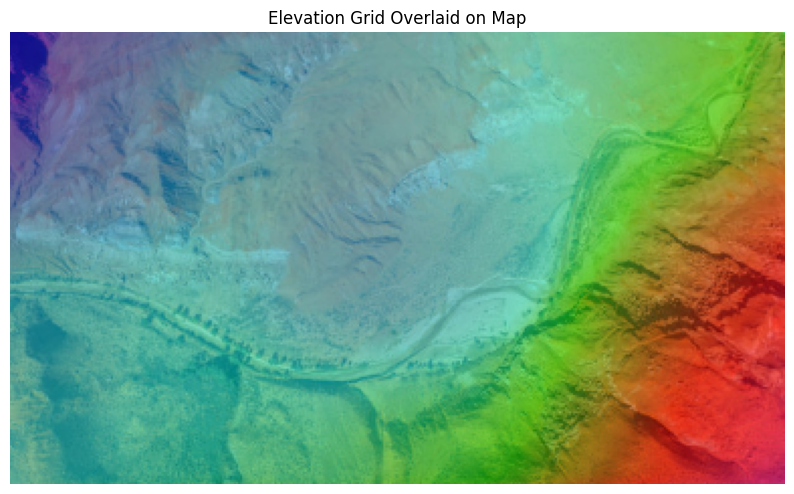

In [25]:
# Load your map image (replace 'terrain_map.jpg' with the path to your map image)
map_image = cv2.imread("/content/terrain.jpg")
map_image = cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)

# Resize the map image to match the elevation grid dimensions
map_image_resized = cv2.resize(map_image, (elevation_grid.shape[1], elevation_grid.shape[0]))

# Normalize elevation grid to range [0, 255] for overlay
elevation_overlay = (elevation_grid / elevation_grid.max() * 255).astype(np.uint8)

# Create a color map representation of the elevation grid
colormap = cv2.applyColorMap(elevation_overlay, cv2.COLORMAP_RAINBOW)

# Blend the map image and elevation overlay
alpha = 0.5  # Transparency level for overlay
blended = cv2.addWeighted(map_image_resized, 1 - alpha, colormap, alpha, 0)

# Display the blended map
plt.figure(figsize=(10, 7))
plt.imshow(blended)
plt.title("Elevation Grid Overlaid on Map")
plt.axis("off")
plt.show()

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

map = cv2.imread("map.png",0)
HEIGHT, WIDTH = map.shape
print(map)

rx, ry, rtheta = (WIDTH/4, HEIGHT/4, 0)

[[ 79  80  82 ... 133 148 156]
 [ 78  79  81 ... 138 156 164]
 [ 76  77  79 ... 147 170 180]
 ...
 [181 181 182 ... 174 172 171]
 [178 178 178 ... 180 179 178]
 [177 177 177 ... 183 182 182]]


Map coordinate system

![title](https://github.com/IronAvenger11-prog/Robot-Localization-with-Python-and-Particle-Filters/blob/main/images/coords.png?raw=1)

CAUTION: The terrain height at X,Y coordinates is map(Y,X).

Read keyboard input.

In [ ]:
STEP = 5
TURN = np.radians(25)

def get_input():
  fwd = 8
  turn = 0
  halt = False
  k = cv2.waitKey(0)
  if k == 82:
    fwd = STEP
  elif k == 83:
    turn = TURN
  elif k == 81:
    turn = -TURN
  else:
    halt = True

  return fwd, turn, halt

Move the robot, with Gausssian noise.

![title](https://github.com/IronAvenger11-prog/Robot-Localization-with-Python-and-Particle-Filters/blob/main/images/gaussian.png?raw=1)

In [ ]:
SIGMA_STEP = 0.5
SIGMA_TURN = np.radians(5)

def move_robot(rx, ry, rtheta, fwd, turn):
  fwd_noisy = np.random.normal(fwd, SIGMA_STEP, 1)
  rx += fwd_noisy*np.cos(rtheta)
  ry += fwd_noisy*np.sin(rtheta)
  print("fwd_noisy = ",fwd_noisy)

  turn_noisy = np.random.normal(turn, SIGMA_TURN, 1)
  rtheta += turn_noisy
  print("turn_noisy = ", np.degrees(turn_noisy))

Initialize particle cloud.

In [ ]:
NUM_PARTICLES = 3000
def init():
  particles = np.random.rand(NUM_PARTICLES, 3)
  particles += np.array([WIDTH, HEIGHT, np.radians(360)])
  return ()

Move the particles.

In [ ]:
def move_particles(particles, fwd, turn):
  particles[:,0] += fwd*np.cos(particles[:,2])
  particles[:,1] += fwd*np.sin(particles[:,2])
  particles[:,2] += turn

  particles[:,0] = np.clip(particles[:,0], 0.0, WIDTH-1)
  particles[:,1] = np.clip(particles[:,1], 0.0, HEIGHT-1)
  return particles

Get value from robot's sensor.

In [ ]:
SIGMA_SENSOR = 2
def sense(x, y, noisy=False):
  x = int(x)
  y = int(y)
  if noisy:
    return np.random.normal(map[y,x], SIGMA_SENSOR, 1)

  return map[y,x]

Compute particle weights.

In [ ]:
def compute_weights(particles, robot_sensor):
  errors = np.zeros(NUM_PARTICLES)
  for i in range(NUM_PARTICLES):
    elevation = sense(particles[i,0], particles[i,1], noisy=False)
    errors[i] = abs(robot_sensor - elevation)
    weights = np.max(errors) - errors
    weights[
            (particles[:,0] == 0)  |
            (particles[:,0] == WIDTH-1)  |
            (particles[:,1] == 0)  |
            (particles[:,1] == HEIGHT-1)  |

    ]
    weights = weights**3
    return weights

Resample the particles.

In [ ]:
def resample(particles, weights):
  probabilities = weights/np.sum(weights)
  new_index = np.random.choice(
      NUM_PARTICLES,
      size = NUM_PARTICLES
      p = probabilities
  )
  particles = particles[new_index,:]

  return particles

Add noise to the particles.

In [ ]:
SIGMA_POS = 2
SIGMA_TURN = np.radians(10)
def add_noise(particles):
  noise = np.concatenate(
      (

          np.random.normal(0, SIGMA_POS, (NUM_PARTICLES, 1)),
          np.random.normal(0, SIGMA_POS, (NUM_PARTICLES, 1)),
          np.random.normal(0, SIGMA_TURN, (NUM_PARTICLES, 1))
      ),
      axis = 1
      )
  particles += noise
  return particles

Display robot, particles and best guess.

In [ ]:
def display(map, rx, ry, particles):
    lmap = cv2.cvtColor(map, cv2.COLOR_GRAY2BGR)

    # Display particles
    if len(particles) > 0:
        for i in range(NUM_PARTICLES):
            cv2.circle(lmap,
                       (int(particles[i,0]), int(particles[i,1])),
                       1,
                       (255,0,0),
                       1)

    # Display robot
    cv2.circle(lmap, (int(rx), int(ry)), 5, (0,255,0), 10)

    # Display best guess
    if len(particles) > 0:
        px = np.mean(particles[:,0])
        py = np.mean(particles[:,1])
        cv2.circle(lmap, (int(px), int(py)), 5, (0,0,255), 5)

    cv2_imshow('map')

Main routine.

In [ ]:
particles = init()
while True:
    display(map, rx, ry, particles)
    fwd, turn, halt = get_input()
    if halt:
        break
    rx, ry, rtheta = move_robot(rx, ry, rtheta, fwd, turn)
    particles = move_particles(particles, fwd, turn)
    if fwd != 0:
        robot_sensor = sense(rx, ry, noisy=True)
        weights = compute_weights(particles, robot_sensor)
        particles = resample(particles, weights)
        particles = add_noise(particles)

cv2.destroyAllWindows()
